# Import

In [1]:
from LibAUC.libauc.losses import MultiLabelAUCMLoss,CrossEntropyLoss
from LibAUC.libauc.optimizers import PESG,Adam
from LibAUC.libauc.models import densenet121 as DenseNet121
from LibAUC.libauc.models import resnet34 as Resnet34
from LibAUC.libauc.models import resnet50 as Resnet50
from LibAUC.libauc.datasets import CheXpert
from LibAUC.libauc.metrics import auc_roc_score # for multi-task

from PIL import Image
import numpy as np
import pandas as pd
import torch 
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2
import shutil
import warnings
import re
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
warnings.simplefilter(action='ignore',category=FutureWarning) # Delete Future Warning

In [3]:
SEED = 123
set_all_seeds(SEED)
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(os.getcwd())


C:\Users\moc90\Library


In [4]:
# (model,version,symptoms)
AUC = np.zeros((3,3,5))

# DenseNet121

In [5]:
# model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
origin_model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
origin_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','origin_model_densenet121.pth')))
male_model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
male_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','male_model_densenet121.pth')))
female_model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
female_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','female_model_densenet121.pth')))
before40_model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
before40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','before40_model_densenet121.pth')))
after40_model = DenseNet121(pretrained=False,last_activation=None,activations='relu',num_classes=5)
after40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','after40_model_densenet121.pth')))

<All keys matched successfully>

In [6]:
files_lst = ['CheXpert_origin']
models_lst = [origin_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
origin_test_true = test_true
origin_test_pred = test_pred
print(f"origin: {val_auc_mean}")

files_lst = ['CheXpert_male','CheXpert_female']
models_lst = [male_model,female_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred))
sex_test_true = test_true
sex_test_pred = test_pred
print(f"sex: {val_auc_mean}")

files_lst = ['CheXpert_before40','CheXpert_after40']
models_lst = [before40_model,after40_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
age_test_true = test_true
age_test_pred = test_pred
print(f"age: {val_auc_mean}")

origin: 0.7986285297560904
sex: 0.7884916441667218
age: 0.7896934597724808


In [7]:
origin_thres = np.zeros(origin_test_true.shape[1])
sex_thres = np.zeros(origin_test_true.shape[1])
age_thres = np.zeros(origin_test_true.shape[1])

for j in range(origin_test_true.shape[1]):
    AUC[0,0,j] = roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j])
    AUC[0,1,j] = roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j])
    AUC[0,2,j] = roc_auc_score(age_test_true[:,j], age_test_pred[:,j])
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]

In [8]:
symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# origin_model
model = origin_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_origin\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'origin_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_densenet121_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_densenet121_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# male_model
model = male_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_male\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'male_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_densenet121_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_densenet121_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# female_model
model = female_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_female\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'female_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_densenet121_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_densenet121_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# before40_model
model = before40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_before40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'before40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_densenet121_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_densenet121_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# after40_model
model = after40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_after40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'after40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_densenet121_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_densenet121_matrix.csv'))

origin_model: 0
origin_model: 1000
origin_model: 1192
male_model: 0
male_model: 698
female_model: 0
female_model: 493
before40_model: 0
before40_model: 178
after40_model: 0
after40_model: 1000
after40_model: 1013


## AUC Plot

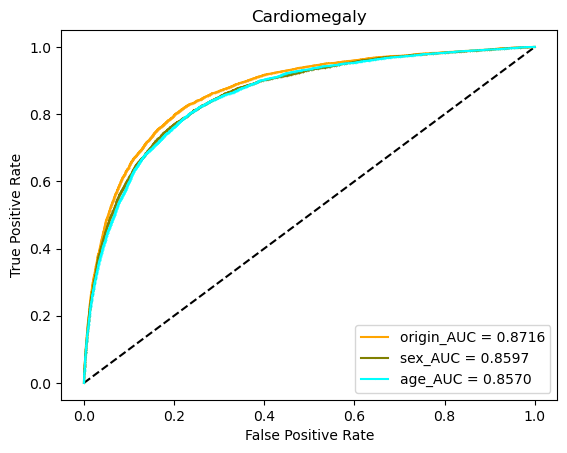

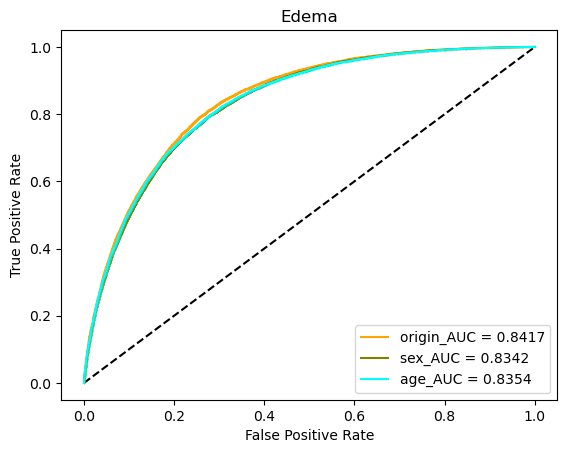

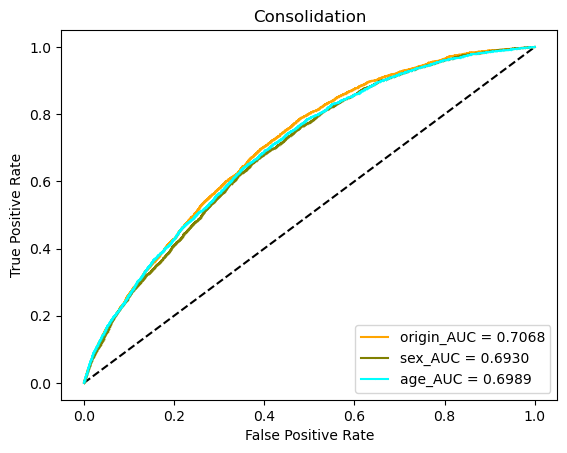

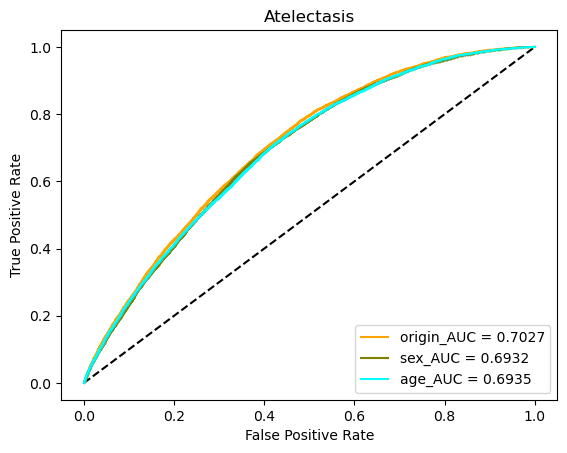

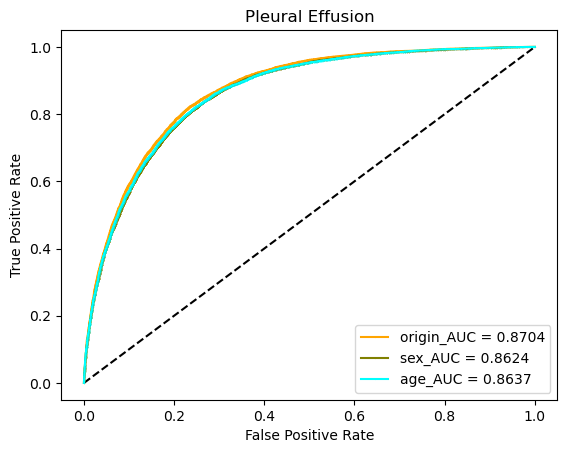

In [9]:
os.makedirs(os.path.join(os.getcwd(),'plot_files'),exist_ok=True)
for j in range(origin_test_true.shape[1]):
    plt.title(symptoms[j])
    plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label=f'origin_AUC = {roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
    #             label=f'origin: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='olive', markersize=0.05, label=f'sex_AUC = {roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='g', 
    #             label=f'sex: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='cyan', markersize=0.05, label=f'age_AUC = {roc_auc_score(age_test_true[:,j], age_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='b', 
    #             label=f'age: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.savefig(os.path.join(os.getcwd(),'plot_files',f'DenseNet121_AUC_{symptoms[j]}.jpg'))
    plt.show()

# ResNet34

In [10]:
# model = Resnet34(pretrained=False,last_activation=None,activations='relu',num_classes=5)
origin_model = Resnet34(pretrained=False,last_activation=None,activations='elu',num_classes=5)
origin_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','origin_model_resnet34.pth')))
male_model = Resnet34(pretrained=False,last_activation=None,activations='elu',num_classes=5)
male_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','male_model_resnet34.pth')))
female_model = Resnet34(pretrained=False,last_activation=None,activations='elu',num_classes=5)
female_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','female_model_resnet34.pth')))
before40_model = Resnet34(pretrained=False,last_activation=None,activations='elu',num_classes=5)
before40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','before40_model_resnet34.pth')))
after40_model = Resnet34(pretrained=False,last_activation=None,activations='elu',num_classes=5)
after40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','after40_model_resnet34.pth')))

<All keys matched successfully>

In [11]:
files_lst = ['CheXpert_origin']
models_lst = [origin_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
origin_test_true = test_true
origin_test_pred = test_pred
print(f"origin: {val_auc_mean}")

files_lst = ['CheXpert_male','CheXpert_female']
models_lst = [male_model,female_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred))
sex_test_true = test_true
sex_test_pred = test_pred
print(f"sex: {val_auc_mean}")

files_lst = ['CheXpert_before40','CheXpert_after40']
models_lst = [before40_model,after40_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
age_test_true = test_true
age_test_pred = test_pred
print(f"age: {val_auc_mean}")

origin: 0.7744106023218784
sex: 0.7694852200231469
age: 0.7685071296804373


In [12]:
origin_thres = np.zeros(origin_test_true.shape[1])
sex_thres = np.zeros(origin_test_true.shape[1])
age_thres = np.zeros(origin_test_true.shape[1])

for j in range(origin_test_true.shape[1]):
    AUC[1,0,j] = roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j])
    AUC[1,1,j] = roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j])
    AUC[1,2,j] = roc_auc_score(age_test_true[:,j], age_test_pred[:,j])
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]

In [13]:
symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# origin_model
model = origin_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_origin\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'origin_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_resnet34_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_resnet34_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# male_model
model = male_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_male\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'male_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_resnet34_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_resnet34_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# female_model
model = female_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_female\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'female_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_resnet34_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_resnet34_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# before40_model
model = before40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_before40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'before40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_resnet34_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_resnet34_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# after40_model
model = after40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_after40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'after40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_resnet34_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_resnet34_matrix.csv'))

origin_model: 0
origin_model: 1000
origin_model: 1192
male_model: 0
male_model: 698
female_model: 0
female_model: 493
before40_model: 0
before40_model: 178
after40_model: 0
after40_model: 1000
after40_model: 1013


## AUC Plot

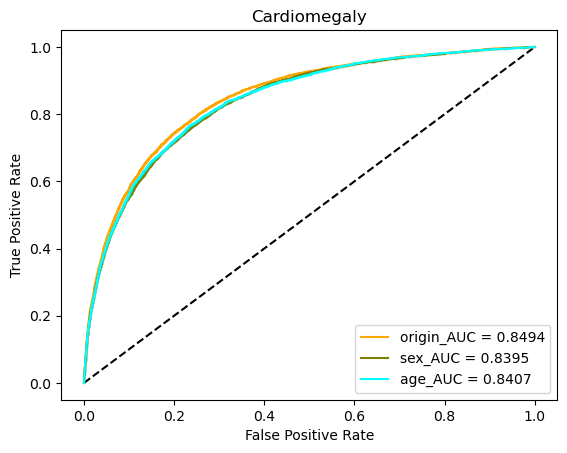

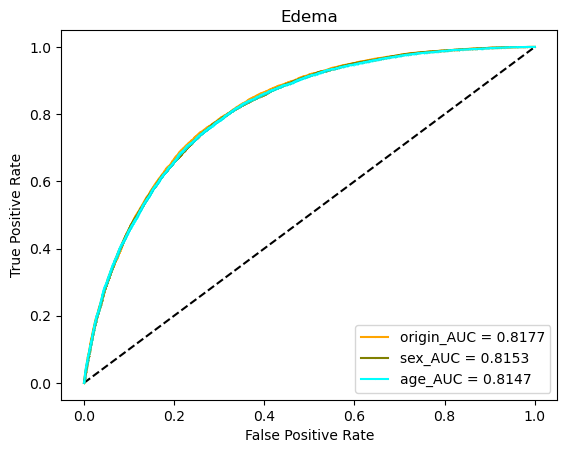

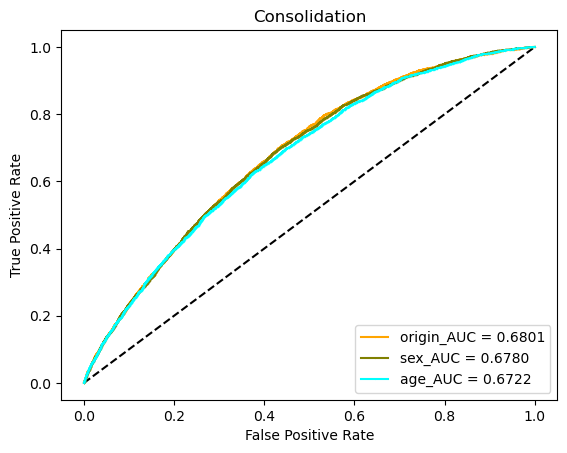

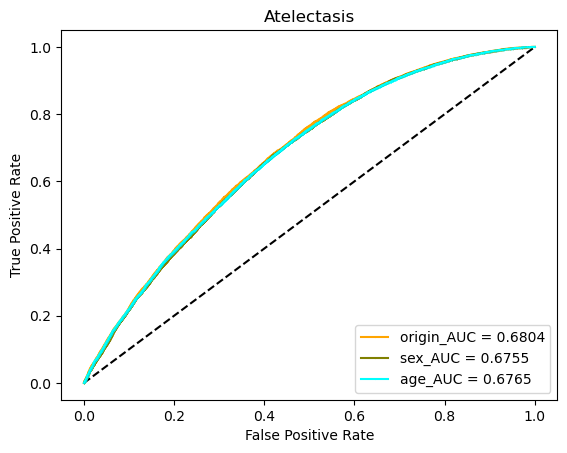

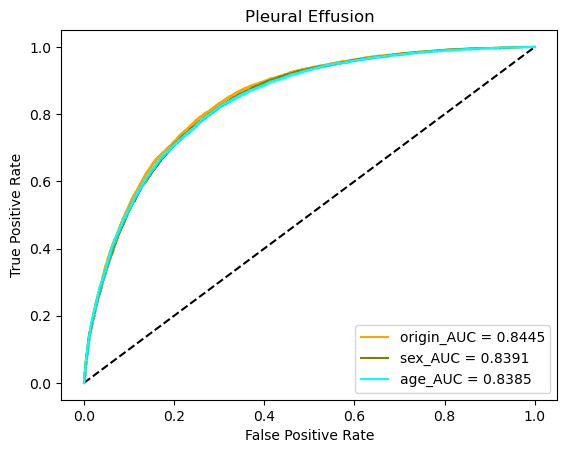

In [14]:
os.makedirs(os.path.join(os.getcwd(),'plot_files'),exist_ok=True)
for j in range(origin_test_true.shape[1]):
    plt.title(symptoms[j])
    plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label=f'origin_AUC = {roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
    #             label=f'origin: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='olive', markersize=0.05, label=f'sex_AUC = {roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='g', 
    #             label=f'sex: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='cyan', markersize=0.05, label=f'age_AUC = {roc_auc_score(age_test_true[:,j], age_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='b', 
    #             label=f'age: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.savefig(os.path.join(os.getcwd(),'plot_files',f'ResNet34_AUC_{symptoms[j]}.jpg'))
    plt.show()

# ResNet50

In [15]:
# model = Resnet50(pretrained=False,last_activation=None,activations='relu',num_classes=5)
origin_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
origin_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','origin_model_resnet50.pth')))
male_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
male_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','male_model_resnet50.pth')))
female_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
female_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','female_model_resnet50.pth')))
before40_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
before40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','before40_model_resnet50.pth')))
after40_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
after40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','after40_model_resnet50.pth')))

<All keys matched successfully>

In [16]:
files_lst = ['CheXpert_origin']
models_lst = [origin_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
origin_test_true = test_true
origin_test_pred = test_pred
print(f"origin: {val_auc_mean}")

files_lst = ['CheXpert_male','CheXpert_female']
models_lst = [male_model,female_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred))
sex_test_true = test_true
sex_test_pred = test_pred
print(f"sex: {val_auc_mean}")

files_lst = ['CheXpert_before40','CheXpert_after40']
models_lst = [before40_model,after40_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
val_auc_mean = np.mean(auc_roc_score(test_true,test_pred)) 
age_test_true = test_true
age_test_pred = test_pred
print(f"age: {val_auc_mean}")

origin: 0.7679482080683551
sex: 0.7626804671322411
age: 0.7622130212641477


In [17]:
origin_thres = np.zeros(origin_test_true.shape[1])
sex_thres = np.zeros(origin_test_true.shape[1])
age_thres = np.zeros(origin_test_true.shape[1])

for j in range(origin_test_true.shape[1]):
    AUC[2,0,j] = roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j])
    AUC[2,1,j] = roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j])
    AUC[2,2,j] = roc_auc_score(age_test_true[:,j], age_test_pred[:,j])
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]

In [18]:
symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# origin_model
model = origin_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_origin\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'origin_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_resnet50_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < origin_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','origin_model_resnet50_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# male_model
model = male_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_male\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'male_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_resnet50_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','male_model_resnet50_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# female_model
model = female_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_female\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'female_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_resnet50_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < sex_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','female_model_resnet50_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# before40_model
model = before40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_before40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'before40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_resnet50_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','before40_model_resnet50_matrix.csv'))

symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
symptoms_matrix_pd = pd.DataFrame(data={'Cardiomegaly':[0,0,0,0],'Edema':[0,0,0,0],'Consolidation':[0,0,0,0],'Atelectasis':[0,0,0,0],'Pleural Effusion':[0,0,0,0]},index=['FN','FP','TN','TP'])

# after40_model
model = after40_model
model.to(device)
root = os.path.join(os.getcwd(),'CheXpert_after40\\')
test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
model.eval()
with torch.no_grad():
    for jdx,data in enumerate(test_loader):
        if jdx % 1000 == 0 or jdx == len(test_loader)-1:
            print(f'after40_model: {jdx}')
            symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_resnet50_matrix.csv'))
        
        test_data,test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                if test_labels[i][j] < 0.5: # Real Negative
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['TN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['FP',symptoms[j]] += 1
                else: # Real Positive
                    if y_pred[i][j] < age_thres[j]: # Predict Negative
                        symptoms_matrix_pd.at['FN',symptoms[j]] += 1
                    else: # Predict Positive
                        symptoms_matrix_pd.at['TP',symptoms[j]] += 1
            
symptoms_matrix_pd.to_csv(os.path.join(os.getcwd(),'matrix_files','after40_model_resnet50_matrix.csv'))

origin_model: 0
origin_model: 1000
origin_model: 1192
male_model: 0
male_model: 698
female_model: 0
female_model: 493
before40_model: 0
before40_model: 178
after40_model: 0
after40_model: 1000
after40_model: 1013


## AUC Plot

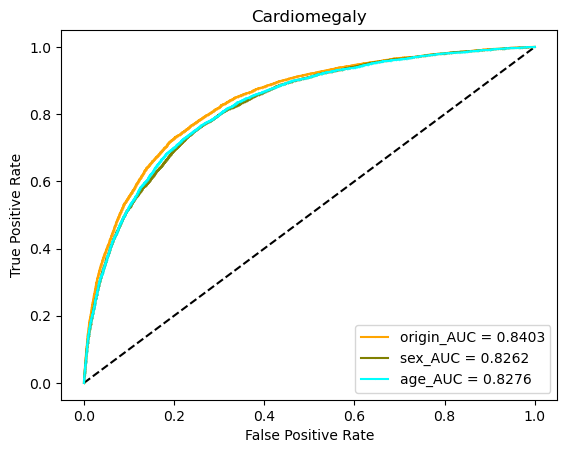

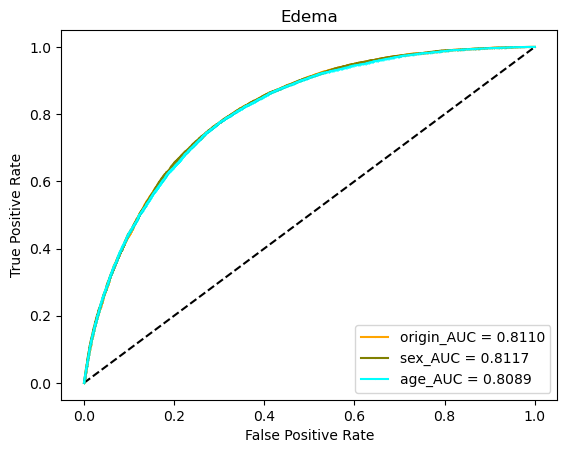

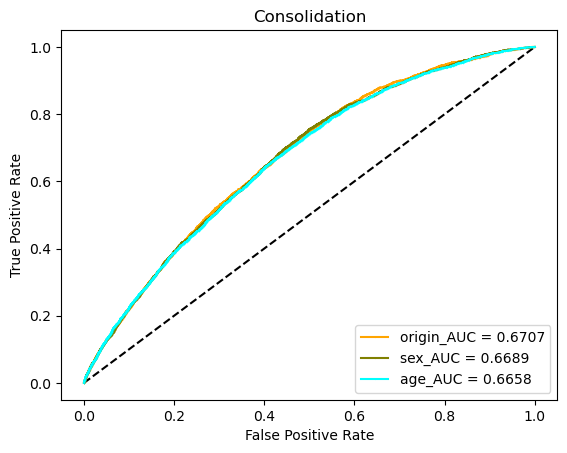

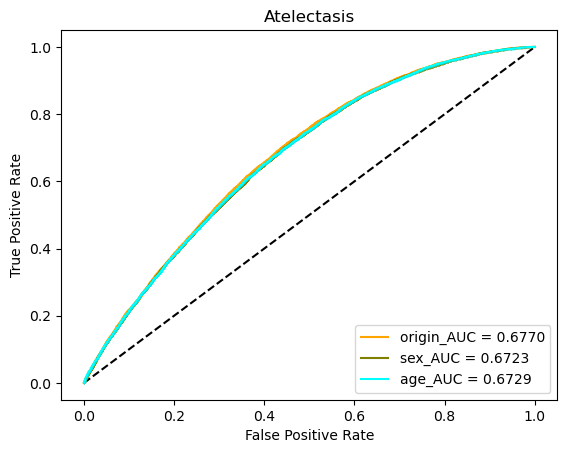

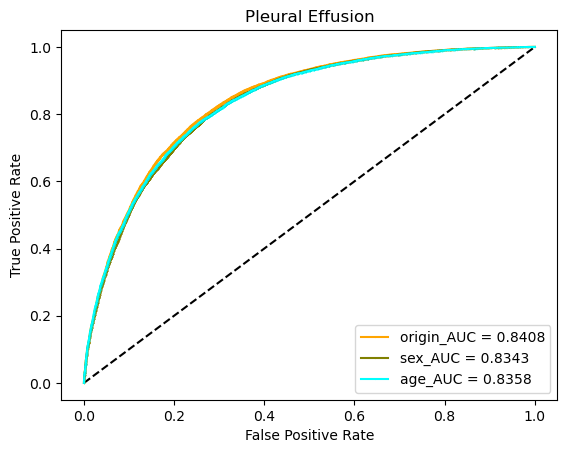

In [19]:
os.makedirs(os.path.join(os.getcwd(),'plot_files'),exist_ok=True)
for j in range(origin_test_true.shape[1]):
    plt.title(symptoms[j])
    plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
    fpr, tpr, thresholds = roc_curve(origin_test_true[:,j], origin_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    origin_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label=f'origin_AUC = {roc_auc_score(origin_test_true[:,j], origin_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
    #             label=f'origin: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(sex_test_true[:,j], sex_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sex_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='olive', markersize=0.05, label=f'sex_AUC = {roc_auc_score(sex_test_true[:,j], sex_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='g', 
    #             label=f'sex: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')

    fpr, tpr, thresholds = roc_curve(age_test_true[:,j], age_test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    age_thres[j] = thresholds[ix]
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='cyan', markersize=0.05, label=f'age_AUC = {roc_auc_score(age_test_true[:,j], age_test_pred[:,j]):.4f}')
    # plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='b', 
    #             label=f'age: (sensitivity,specificity) = ({sens:.3f},{spec:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.savefig(os.path.join(os.getcwd(),'plot_files',f'ResNet50_AUC_{symptoms[j]}.jpg'))
    plt.show()

In [21]:
np.savetxt(os.path.join(os.getcwd(),'matrix_files','AUC_DenseNet121.csv'),AUC[0,:,:],delimiter=',')
np.savetxt(os.path.join(os.getcwd(),'matrix_files','AUC_ResNet34.csv'),AUC[1,:,:],delimiter=',')
np.savetxt(os.path.join(os.getcwd(),'matrix_files','AUC_ResNet50.csv'),AUC[2,:,:],delimiter=',')

In [30]:
symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
print(AUC)
for j in range(5):
    x1 = np.array(np.squeeze(AUC[:,0,j]))
    x2 = np.array(np.squeeze(AUC[:,1,j]))
    x3 = np.array(np.squeeze(AUC[:,2,j]))
    print(symptoms[j])
    print(f"p-value(origin & sex) = {np.round(stats.ttest_ind(x1, x2, equal_var=False)[1],4)}")
    print(f"p-value(origin & age) = {np.round(stats.ttest_ind(x1, x3, equal_var=False)[1],4)}")
    print()
x1 = np.array(np.mean(AUC[:,0,:],axis=1))
x2 = np.array(np.mean(AUC[:,1,:],axis=1))
x3 = np.array(np.mean(AUC[:,2,:],axis=1))
print(f"AUCM")
print(f"p-value(origin & sex) = {np.round(stats.ttest_ind(x1, x2, equal_var=False)[1],4)}")
print(f"p-value(origin & age) = {np.round(stats.ttest_ind(x1, x3, equal_var=False)[1],4)}")

[[[0.87160003 0.84172123 0.70676063 0.70270118 0.87035958]
  [0.85969782 0.83419047 0.6929723  0.69317495 0.86242268]
  [0.85695355 0.83540337 0.69885309 0.69353073 0.86372656]]

 [[0.84938267 0.81774529 0.68007342 0.68039506 0.84445657]
  [0.83949268 0.81530117 0.67800939 0.67552918 0.83909367]
  [0.84065582 0.81469393 0.67218981 0.67653255 0.83846354]]

 [[0.84027196 0.81101214 0.67065751 0.67702569 0.84077374]
  [0.82621357 0.81166055 0.66894309 0.67229474 0.83429039]
  [0.82763781 0.80888974 0.66584145 0.67293127 0.83576484]]]
Cardiomegaly
p-value(origin & sex) = 0.4251
p-value(origin & age) = 0.3948

Edema
p-value(origin & sex) = 0.8037
p-value(origin & age) = 0.7716

Consolidation
p-value(origin & sex) = 0.6767
p-value(origin & age) = 0.6669

Atelectasis
p-value(origin & sex) = 0.5725
p-value(origin & age) = 0.609

Pleural Effusion
p-value(origin & sex) = 0.632
p-value(origin & age) = 0.6719

AUCM
p-value(origin & sex) = 0.6068
p-value(origin & age) = 0.6129


In [24]:
print(np.mean(AUC,axis=2))

[[0.79862853 0.78849164 0.78969346]
 [0.7744106  0.76948522 0.76850713]
 [0.76794821 0.76268047 0.76221302]]


In [44]:
sensitivity_specificity_pd = pd.read_csv(os.path.join(os.getcwd(),'matrix_files','sensitivity_specificity.csv'))
columns=['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion','Total']
print('sensitivity')
for j in range(len(columns)):
    x1 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='sensitivity') & (sensitivity_specificity_pd['OSO']=='origin')].to_numpy()[:,3+j].astype(np.float16)
    x2 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='sensitivity') & (sensitivity_specificity_pd['OSO']=='sex')].to_numpy()[:,3+j].astype(np.float16)
    x3 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='sensitivity') & (sensitivity_specificity_pd['OSO']=='age')].to_numpy()[:,3+j].astype(np.float16)
    print(columns[j])
    print(f"p-value(origin & sex) = {np.round(stats.ttest_ind(x1, x2, equal_var=False)[1],4)}")
    print(f"p-value(origin & age) = {np.round(stats.ttest_ind(x1, x3, equal_var=False)[1],4)}")
    print()
    
print('specificity')
for j in range(len(columns)):
    x1 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='specificity') & (sensitivity_specificity_pd['OSO']=='origin')].to_numpy()[:,3+j].astype(np.float16)
    x2 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='specificity') & (sensitivity_specificity_pd['OSO']=='sex')].to_numpy()[:,3+j].astype(np.float16)
    x3 = sensitivity_specificity_pd[(sensitivity_specificity_pd['SS']=='specificity') & (sensitivity_specificity_pd['OSO']=='age')].to_numpy()[:,3+j].astype(np.float16)
    print(columns[j])
    print(f"p-value(origin & sex) = {np.round(stats.ttest_ind(x1, x2, equal_var=False)[1],4)}")
    print(f"p-value(origin & age) = {np.round(stats.ttest_ind(x1, x3, equal_var=False)[1],4)}")
    print()

sensitivity
Cardiomegaly
p-value(origin & sex) = 0.644
p-value(origin & age) = 0.9719

Edema
p-value(origin & sex) = 0.8161
p-value(origin & age) = 0.709

Consolidation
p-value(origin & sex) = 0.8854
p-value(origin & age) = 0.1915

Atelectasis
p-value(origin & sex) = 0.1255
p-value(origin & age) = 0.3015

Pleural Effusion
p-value(origin & sex) = 0.8927
p-value(origin & age) = 0.811

Total
p-value(origin & sex) = 0.55
p-value(origin & age) = 0.6216

specificity
Cardiomegaly
p-value(origin & sex) = 0.6007
p-value(origin & age) = 0.2798

Edema
p-value(origin & sex) = 0.3149
p-value(origin & age) = 0.2276

Consolidation
p-value(origin & sex) = 0.9015
p-value(origin & age) = 0.1307

Atelectasis
p-value(origin & sex) = 0.0622
p-value(origin & age) = 0.2621

Pleural Effusion
p-value(origin & sex) = 0.3456
p-value(origin & age) = 0.6764

Total
p-value(origin & sex) = 0.8684
p-value(origin & age) = 0.1586



C:\Users\moc90\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
